# WIND SPEED in Madrid - Time Series Analysis

# 1. Dataset Selection

For this project, we will utilize the Open-Meteo API to extract historical weather data for Madrid, focusing on mean temperature, daylight duration, and wind speed over the past decade (2014–2024). Our objective is to conduct an exploratory data analysis, apply time series modeling techniques such as ARMA, ARIMA, and Seasonal ARIMA, and ultimately generate a forecast for the upcoming year (2025).

Throughout this study, we will evaluate multiple models, justify the selection of model parameters, analyze residuals to assess model quality, and validate forecast accuracy. To achieve this, we will perform statistical tests such as the Dickey-Fuller test to assess stationarity and the Ljung-Box test to check for white noise in residuals.

Additionally, we will utilize the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to analyze dependencies within the data. Model performance and fit will be assessed using key statistical criteria, including the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

## 1.1 Import of Libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import requests_cache
import openmeteo_requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from retry_requests import retry
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## 1.2 Extracting the data from the API

In [2]:
def get_data(start_date, end_date):

    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 40.416775,
        "longitude": -3.70379,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_mean", "daylight_duration", "wind_speed_10m_max"],
        "timezone": "Europe/Berlin"
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]

    daily = response.Daily()
    daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
    daily_daylight_duration = daily.Variables(1).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["mean_temp"] = daily_temperature_2m_mean
    daily_data["daylight_duration"] = daily_daylight_duration
    daily_data["wind_speed"] = daily_wind_speed_10m_max

    df = pd.DataFrame(data = daily_data)
    return df

## 1.3 Final Dataset

In [3]:
df = get_data('2015-01-02', '2024-12-31')
df.head()

,date,mean_temp,daylight_duration,wind_speed
0,2015-01-01 23:00:00+00:00,2.219167,33689.375000,4.553679
1,2015-01-02 23:00:00+00:00,3.154583,33736.871094,7.952660
2,2015-01-03 23:00:00+00:00,3.992084,33788.410156,5.411986
3,2015-01-04 23:00:00+00:00,4.431667,33843.882812,8.373386
4,2015-01-05 23:00:00+00:00,3.227500,33903.152344,9.000000


# 2. Exploratory Data Analysis (EDA)

In this phase, we will conduct a comprehensive examination of the dataset to understand its underlying structure and characteristics.
First, we will visualize the data over time to identify general trends, fluctuations, and potential anomalies. We will also assess the presence of missing values and outliers, applying appropriate techniques for handling them to ensure data integrity.

To explore seasonality and periodicity, we will decompose the time series in its trend, seasonal and residual component using Additive and Multiplicative Decomposition.

Additionally, we will utilize the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to examine the correlation structure within the time series. These visualizations will help determine the presence of lagged relationships and guide the selection of appropriate time series model.

## 2.1 Plot the Variables

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

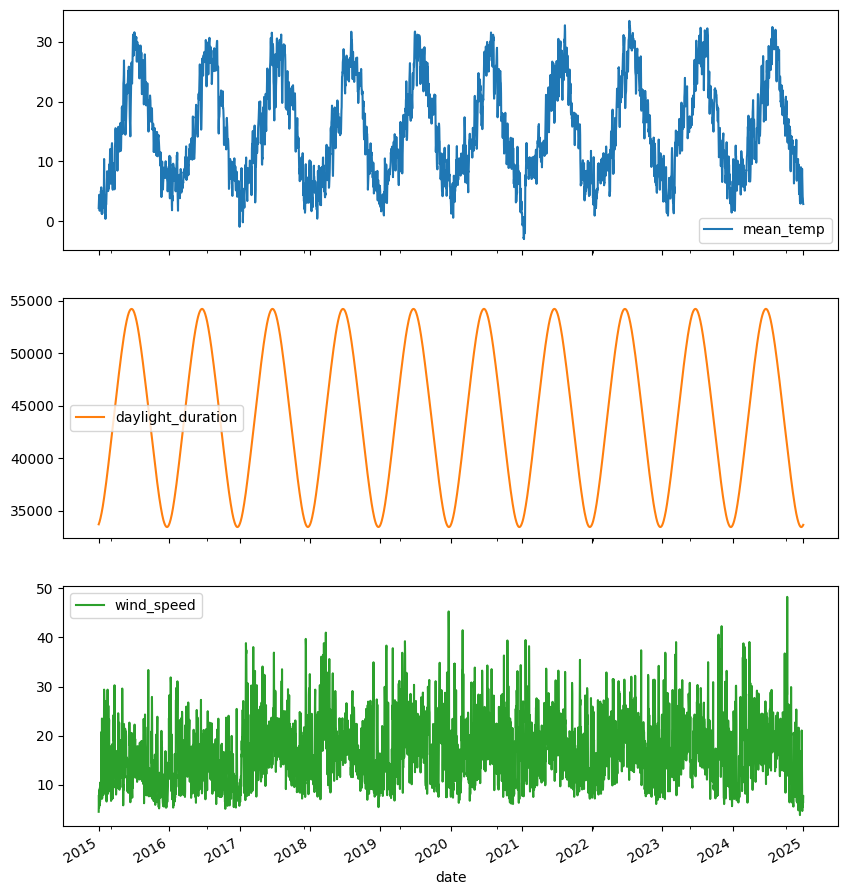

In [4]:
# Converting the date column into a timestamp and setting it as index
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.set_index('date', inplace=True)

# Plotting the time series
df.plot(subplots=True, figsize=(10, 12))

## 2.2 Checking for null values

In [5]:
# Checkin for null values
df.isna().sum()

mean_temp            0
daylight_duration    0
wind_speed           0
dtype: int64

## 2.3 Summary of Descriptive Statistics

In [6]:
df.describe()

,mean_temp,daylight_duration,wind_speed
count,3652.000000,3652.000000,3652.000000
mean,15.293640,43933.132812,17.084154
std,8.195310,7139.462891,6.670321
min,-2.970000,33426.156250,3.885665
25%,8.409167,37019.087891,11.877612
50%,14.153751,44028.033203,16.622490
75%,21.904688,50872.005859,21.227023
max,33.490414,54205.847656,48.214806


## 2.4 Searching for outliers

In [7]:
# Calculate the mean and standard deviation for each column
mean_values = df.mean()
std_values = df.std()

# Define the upper and lower bounds for outliers
upper_bounds = mean_values + 3 * std_values
lower_bounds = mean_values - 3 * std_values

# Identify outliers for each column
outliers = pd.DataFrame()
for column in df.columns:
    outliers[column] = df[(df[column] > upper_bounds[column]) | (df[column] < lower_bounds[column])][column]

# Display the outliers
outliers.count()

mean_temp             0
daylight_duration     0
wind_speed           26
dtype: int64

### After reviewing the data, we determine that 'wind_speed" is our variable of interest.

## 2.5 ACF and PACF plots

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are essential tools for analyzing the dependencies within a time series and determining its stationarity.

The ACF measures dependence between observations at different lags. A slow decay in the ACF plot indicates the presence of a trend, suggesting that the series may be non-stationary. If the ACF drops to zero quickly, it suggests a stationary process.

The PACF helps identify the direct relationship between a time series and its lagged values by controlling for the effects of intermediate lags. This is particularly useful for determining the appropriate order of an autoregressive (AR) model (which we will run after the analysis), as significant spikes in the PACF indicate the number of lag terms that should be included.

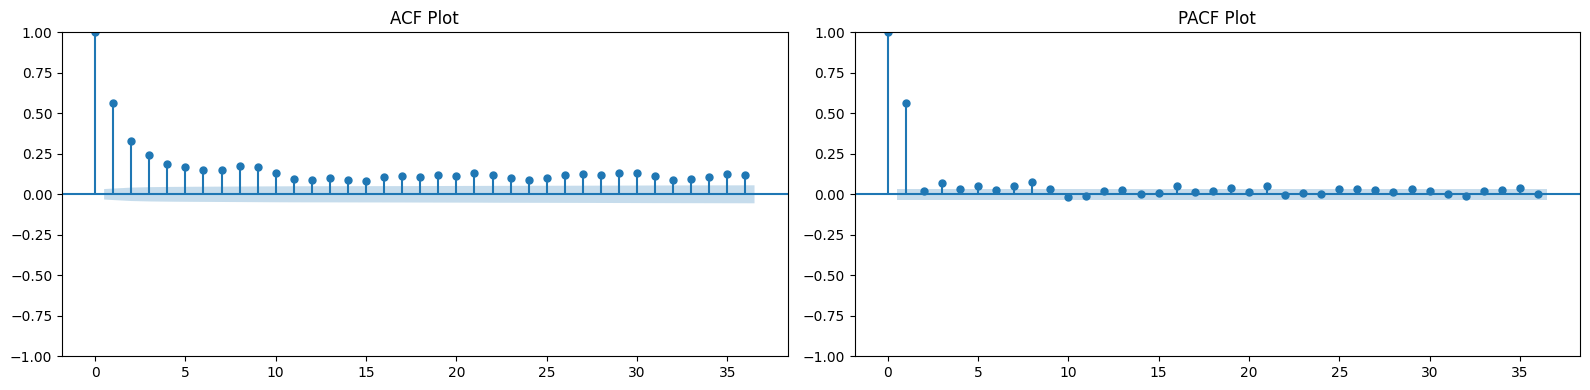

In [8]:
# Create a figure with two subplots: one for ACF and one for PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Generate the ACF plot for the 'wind_speed' column
plot_acf(df['wind_speed'], ax=ax[0])
ax[0].set_title("ACF Plot")

# Generate the PACF plot for the 'wind_speed' column
plot_pacf(df['wind_speed'], ax=ax[1])
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

## 2.6 Dickey-Fuller Test

The Dickey-Fuller test is a statistical method used to assess the stationarity of a time series. The test's null hypothesis states that the series is non-stationary. If the p-value obtained from the test is below 0.05 (assuming a 95% confidence level), we can reject the null hypothesis and conclude that the time series is stationary.

In [9]:
# Perform ADF Test
adf_result = adfuller(df['wind_speed'])

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF Statistic: -8.5751
p-value: 0.0000


# 3. Modeling Process

At this stage, we explore different modeling approaches to ensure the most reliable and accurate forecast. Specifically, we implement and compare three types of models: Autoregressive (AR), Autoregressive Moving Average (ARMA), and Autoregressive Integrated Moving Average (ARIMA). By evaluating these models, we aim to identify the best fit for capturing the underlying patterns in the wind speed time series.

## 3.1 Decomposition of the time series

Here, we perform a time series decomposition to analyze the underlying components of the data. This process allows us to separately examine the trend, seasonal patterns, and residuals, providing valuable insights into the structure of the wind speed time series.

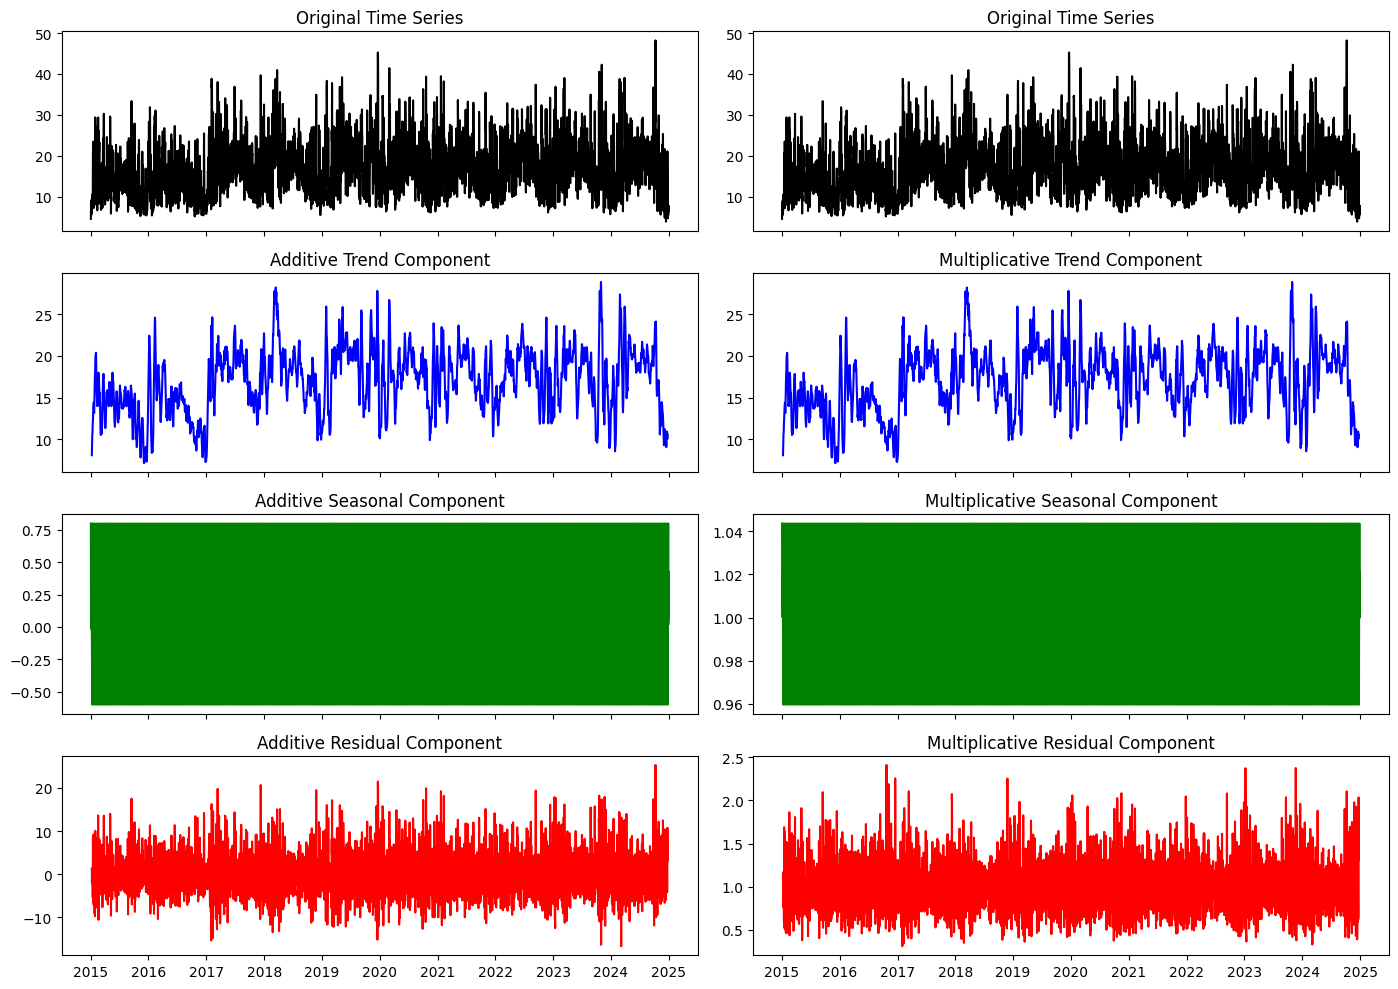

In [10]:
# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(df["wind_speed"], model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(df["wind_speed"], model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(df.index, df["wind_speed"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(df.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(df.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(df.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(df.index, df["wind_speed"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(df.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(df.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(df.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()


## 3.2 Dickey-Fuller and Ljung-Box Test for Residuals

To ensure the validity of our time series model, we analyze the residuals. Ideally, residuals should exhibit no autocorrelation and behave as white noise, indicating that the model has effectively captured all patterns in the data.

We apply the Dickey-Fuller test to the residuals to check for stationarity and also we apply Ljung-Box test which evaluates whether the residuals present significant autocorrelation at multiple lags. A high p-value in this test indicates that the residuals are uncorrelated, confirming that the model has successfully captured the time series structure. If the Ljung-Box test suggests significant autocorrelation, it may indicate that the model needs further refinement.

By performing these tests, we validate the quality of our model and ensure that it meets the fundamental assumptions required for reliable forecasting.

We use the additive approach because:
- The trend does not appear to be multiplicative, so an additive model is preferable.
- Since seasonality does not grow or shrink proportionally with the data, an additive model is more appropriate
- The additive model handles residuals better, with fewer distortions.

In [11]:
# Here we perform ADF Test on Residuals (Assuming Additive is Best)
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF Statistic: -21.3203
p-value: 0.0000


In [12]:
# Here we Perform Ljung-Box Test
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")

Ljung-Box p-value: 0.0000


## 3.3 Performing ADF Test on Residuals
We next ask ourselves if the residuals of the additive decomposition are stationary. If not, it means that there are additional patterns in the data that the decomposition did not pick up. The Dickey-Fuller Test and the ACF will confirm that the residuals are stationary.

In [13]:
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

# additive residual component is stationary, confirmed by the p-value

ADF Statistic: -21.3203
p-value: 0.0000


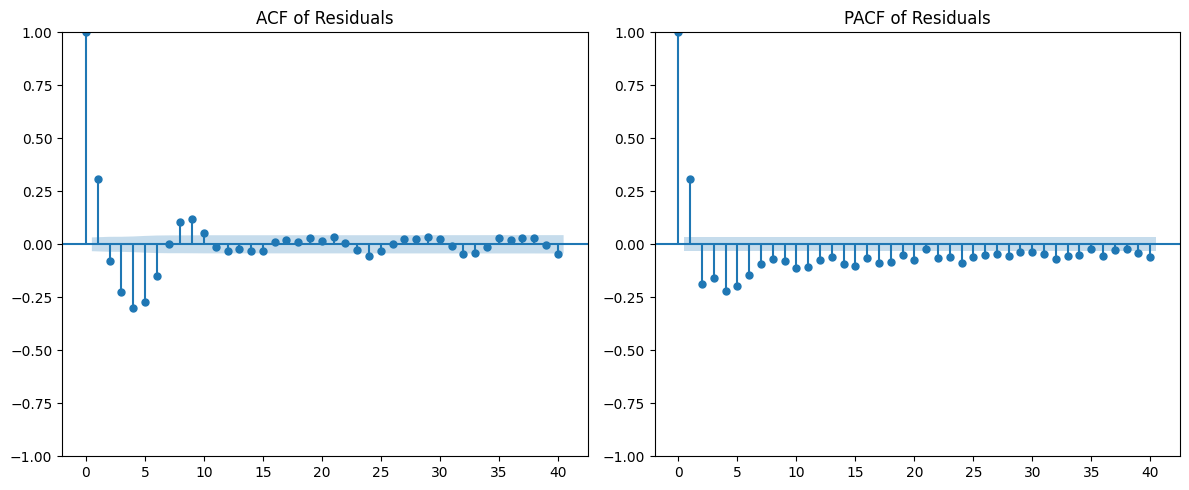

In [14]:
# ACF and PACF Plots of Residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=40, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()

Last, we use the Ljung-Box test, checking if the first 20 autocorrelations are all zero. The p-value tells us that the residual component are not white noise, since there's correlation between observations.

In [15]:
# --- Perform Ljung-Box Test ---
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")

# We reject the null hypothesis, so data is not white noise

Ljung-Box p-value: 0.0000


## 3.4 Model #1: AR

### 3.4.1 Choosing the optimal parameter p

According to the PACF, we consider using an AR(1) model since the only significant PACF is at lag 1 (as shown below).

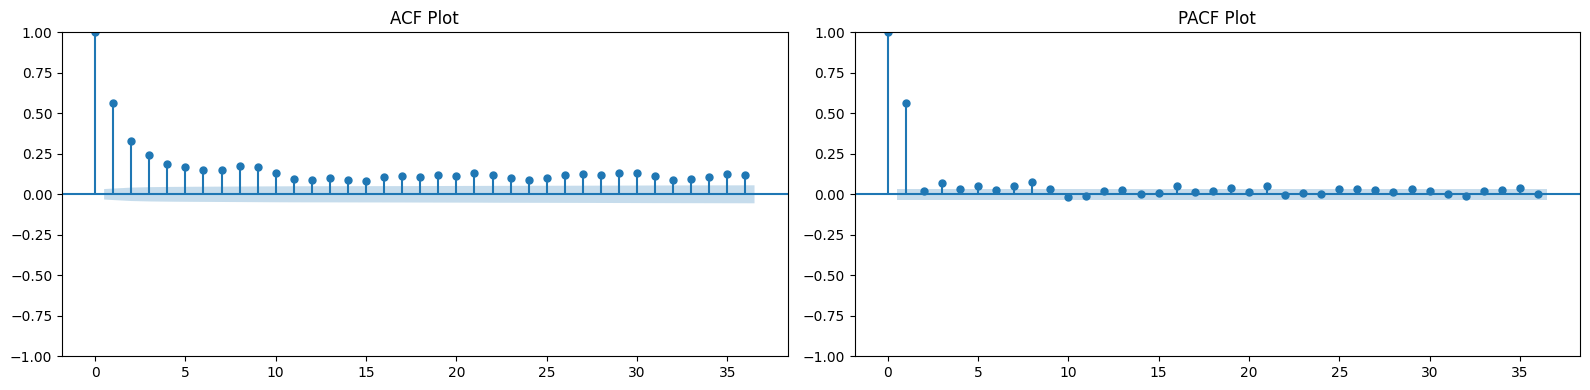

In [16]:
# Now we plot again the ACF and PACF for the new column
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Generate the ACF plot for the 'wind_speed_diff1' column
plot_acf(df['wind_speed'], ax=ax[0])
ax[0].set_title("ACF Plot")

# Generate the PACF plot for the 'wind_speed_diff1' column
plot_pacf(df['wind_speed'], ax=ax[1])
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

Although the PACF model looks quite clear about which model would be best, we used a machine-learning approach to compute the BIC and AIC of all AR(p) models for p from 1 to 10 (Will pick the lowest Value for BIC - Bayesian Information Criteria). In this case the best model is AR(8)

In [17]:
# List to store results for each AR(p) model
results = []

# Fit AR(p) models for p = 1 to 10 and record AIC and BIC
for p in range(1, 11):
    model = ARIMA(df['wind_speed'], order=(p, 0, 0))
    res = model.fit()
    results.append({'p': p, 'AIC': res.aic, 'BIC': res.bic})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the table of AIC and BIC values
print(results_df)

    p           AIC           BIC
0   1  22835.394942  22854.004033
1   2  22835.983744  22860.795865
2   3  22818.990893  22850.006044
3   4  22816.938117  22854.156298
4   5  22810.006386  22853.427597
5   6  22808.987058  22858.611300
6   7  22801.369159  22857.196431
7   8  22782.691902  22844.722205
8   9  22781.339999  22849.573332
9  10  22782.742316  22857.178679


In [18]:
# Fit an AR(8) model (i.e., ARIMA(7, 0, 0)), since it presents the lowest BIC
model = ARIMA(df['wind_speed'], order=(8, 0, 0))
results = model.fit()

# Print the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                 3652
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -11381.346
Date:                Thu, 06 Mar 2025   AIC                          22782.692
Time:                        11:04:46   BIC                          22844.722
Sample:                    01-01-2015   HQIC                         22804.782
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0574      0.326     52.320      0.000      16.418      17.696
ar.L1          0.5405      0.015     35.608      0.000       0.511       0.570
ar.L2         -0.0240      0.017     -1.372      0.1

### 3.4.2 Residual Analysis AR(8)

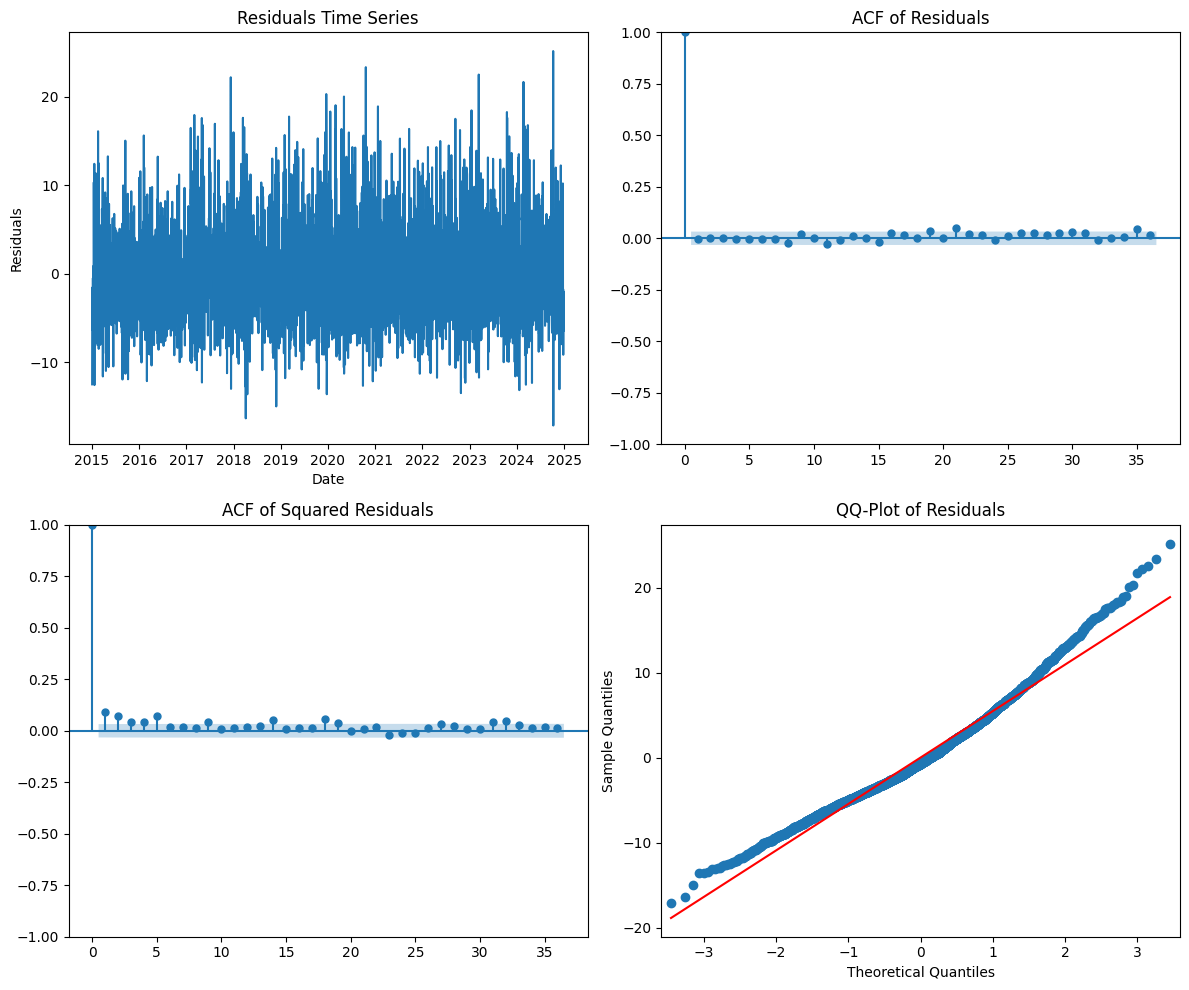

In [19]:
# Fit an AR(8) model and obtain residuals
model = ARIMA(df['wind_speed'], order=(8, 0, 0))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

Our conclusions on the residuals for AR(8) Model are:

- Residuals are centered around zero.
- No significant autocorrelation in ACF plot (white noise residuals).
- Stable variance (minimal heteroskedasticity).
- Some mild autocorrelation in squared residuals, what suggests slight variance instability.
- Heavy tails in QQ-plot, meaning that forecasts may underestimate extreme variations.

Therefore, AR(8) is valid for forecasting, especially short-term.

### 3.4.3 Define Train and Test Sets

We create Train and Test sets to properly evaluate the forecasting model’s performance before using it for real predictions.
Splitting data ensures the model is trained only on past observations and tested on unseen future data (just like real-world forecasting).

We define the training set using data from 2015 to 2023, while the test set consists of wind speed values for 2024. The test set will be used to evaluate the model’s performance by comparing its forecasts to actual observed values.

This approach ensures that the model is tested on a full year of future data, making it particularly effective for assessing seasonal patterns and overall forecasting accuracy

In [20]:
# Split into training (2015-2023) and test (2024)
train = df[df.index.year < 2024]
test = df[df.index.year == 2024]
train_plot = df[df.index.year == 2023]  # Last full year for reference

### 3.4.4 Forecast

For forecasting we will run 2 types of forecast
1. In the left graph, we use a One-Step Ahead Forecast, a dynamic forecasting approach where the model predicts one step at a time, continuously updating with each new actual observation (without retraining). The red line represents the forecast, closely following the general pattern of the black line, which corresponds to the actual 2024 data. This alignment indicates that the model successfully captures key trends in the time series. Additionally, the shaded red area represents the confidence interval, which remains relatively narrow. This suggests low uncertainty in short-term predictions, reinforcing the reliability of the model for near-future forecasts.

2. In the right graph, we present a 12-month forecast, where the green line represents a fixed forecast starting from December 31, 2023. This forecast extends over a full year, providing insights into long-term trends. The shaded green area represents the confidence interval, which expands over time, reflecting increased uncertainty in long-term predictions. While the forecast effectively captures seasonal patterns, it smooths out short-term fluctuations, potentially missing some variations. This approach is particularly useful for long-term forecasting, as it provides a general trend outlook. However, the growing uncertainty highlights the inherent challenge of making precise predictions further into the future.

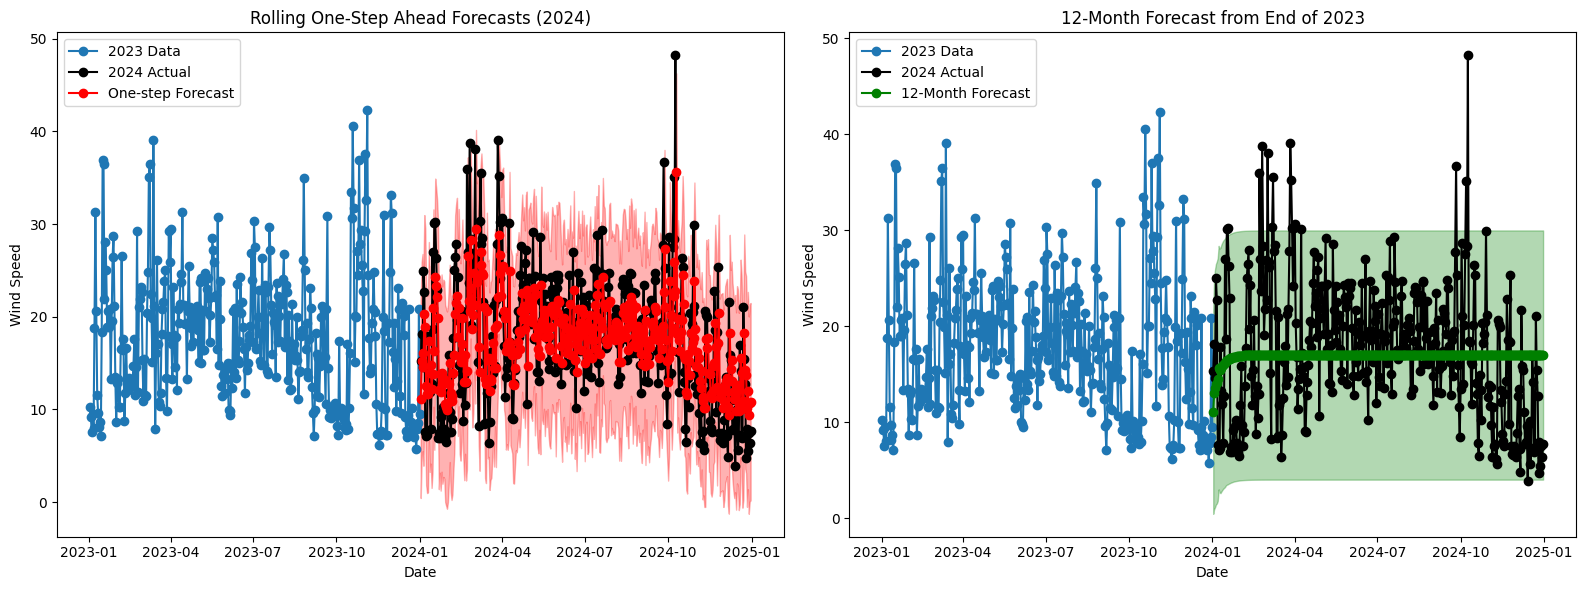

In [21]:
# **12-Month Forecast from the end of 2023**
ar_model = sm.tsa.ARIMA(train['wind_speed'], order=(8, 0, 0)).fit()
forecast_res = ar_model.get_forecast(steps=len(test))
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# **Rolling One-Step Ahead Forecast**
current_results = ar_model  # Use the trained model
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []

for date in test.index:
    # Forecast one step ahead
    forecast_obj = current_results.get_forecast(steps=1)
    forecast_value = forecast_obj.predicted_mean.iloc[0]
    ci = forecast_obj.conf_int()

    # Store forecast and confidence intervals
    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci.iloc[0, 0])
    one_step_ci_upper.append(ci.iloc[0, 1])

    # Update model state with actual observation without refitting
    new_observation = pd.Series(test.loc[date, 'wind_speed'], index=[date], name='wind_speed')
    current_results = current_results.append(new_observation, refit=False)

# Convert forecasts and confidence intervals to Pandas Series
one_step_forecasts = pd.Series(one_step_forecasts, index=test.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test.index)

# **Plotting**
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# **Left Plot: Rolling One-Step Ahead Forecasts**
axes[0].plot(train_plot.index, train_plot['wind_speed'], label='2023 Data', marker='o')
axes[0].plot(test.index, test['wind_speed'], label='2024 Actual', color='black', marker='o')
axes[0].plot(one_step_forecasts.index, one_step_forecasts, label='One-step Forecast', color='red', marker='o')
axes[0].fill_between(one_step_forecasts.index, one_step_ci_lower, one_step_ci_upper, color='red', alpha=0.3)
axes[0].set_title("Rolling One-Step Ahead Forecasts (2024)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Wind Speed")
axes[0].legend()

# **Right Plot: 12-Month Forecast from End of 2023**
axes[1].plot(train_plot.index, train_plot['wind_speed'], label='2023 Data', marker='o')
axes[1].plot(test.index, test['wind_speed'], label='2024 Actual', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label='12-Month Forecast', color='green', marker='o')
axes[1].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
axes[1].set_title("12-Month Forecast from End of 2023")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Wind Speed")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.5 Model #2: ARMA

### 3.5.1 Choosing the optimal parameters (p, q)
To determine the optimal combination of parameters (p, q) for the ARMA model, we will run a selection process that evaluates multiple parameter combinations. The Bayesian Information Criterion (BIC) will be used as the primary criterion for model selection, as it effectively balances model fit and complexity. Additionally, the Akaike Information Criterion (AIC) will serve as a secondary metric to further guide the selection of the best-performing model.

In [22]:
# Define range for AR (p) and MA (q) orders to test
p = q = range(0, 5)  # Testing values from 0 to 4
pq_combinations = list(itertools.product(p, q))

# Initialize tracking variables
best_bic = np.inf  # Start with a high BIC value
best_aic = np.inf  # Start with a high AIC value
best_order = None

# Loop through each (p, q) combination and fit an ARMA model
for order in pq_combinations:
    try:
        model = sm.tsa.ARIMA(train['wind_speed'], order=(order[0], 0, order[1])).fit()
        aic = model.aic  # Extract AIC
        bic = model.bic  # Extract BIC
        
        # First, prioritize the lowest BIC
        if bic < best_bic:
            best_bic, best_aic, best_order = bic, aic, order
        # If two models have the same BIC, choose the one with the lowest AIC
        elif bic == best_bic and aic < best_aic:
            best_aic, best_order = aic, order
    except:
        continue  # Skip models that fail to converge

# Display the best ARMA model based on BIC (first) and AIC (second)
print(f"Best ARMA Order: {best_order}, BIC: {best_bic}, AIC: {best_aic}") 

Best ARMA Order: (2, 2), BIC: 20490.995663362795, AIC: 20454.40927992081


In [23]:
# Fit the ARMA(2,2) model on the training data
arma_model = sm.tsa.ARIMA(train['wind_speed'], order=(2, 0, 2)).fit()

# Display model summary
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                 3287
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -10221.205
Date:                Thu, 06 Mar 2025   AIC                          20454.409
Time:                        11:07:20   BIC                          20490.996
Sample:                    01-01-2015   HQIC                         20467.508
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.8539      0.692     24.342      0.000      15.497      18.211
ar.L1          1.4088      0.035     40.394      0.000       1.340       1.477
ar.L2         -0.4152      0.034    -12.361      0.0

### 3.5.2 Residual Analysis for ARMA(2, 2)

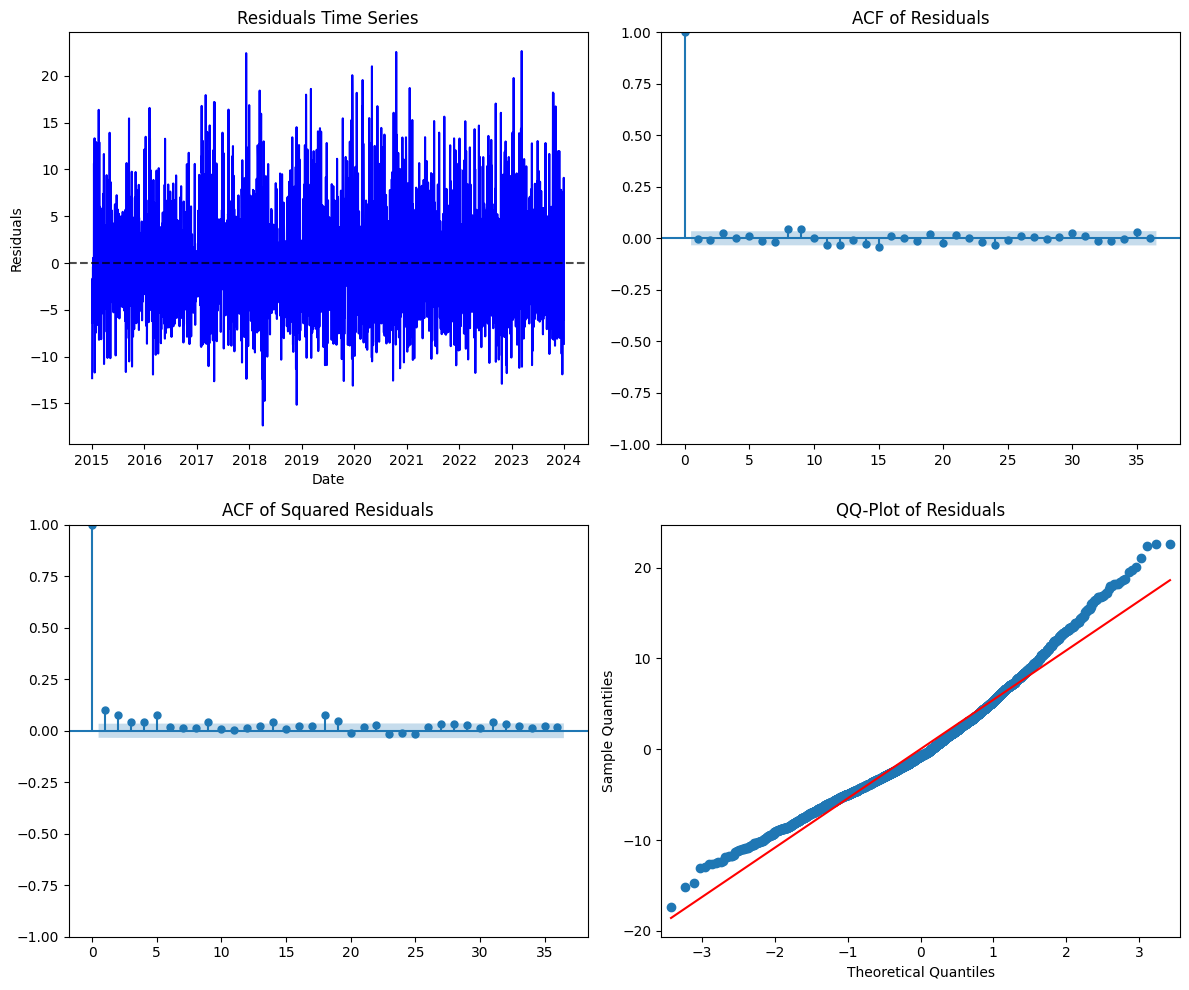

In [24]:
# Fit the ARMA(2,2) model and obtain residuals
model = sm.tsa.ARIMA(train['wind_speed'], order=(2, 0, 2))
results = model.fit()
resid = results.resid  # Extract residuals

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Time Series Plot of Residuals
axes[0, 0].plot(resid, color='blue')
axes[0, 0].axhline(y=0, linestyle="--", color="black", alpha=0.7)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# ACF Plot of Residuals**
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# ACF Plot of Squared Residuals** (Checks for conditional heteroskedasticity)
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# QQ-Plot of Residuals** (Checks for normality)
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

Our conclusions on the residuals for ARMA(2, 2) Model are:

- No major autocorrelation in residuals (ACF plot looks fine) and Residuals are centered around zero (good mean behavior).
- ACF of squared residuals suggests variance is not stable (heteroskedasticity), and Q-Q plot shows heavy tails, meaning forecast errors could be large in extreme cases.
- ARMA(2,2) model is acceptable for short-term forecasting, but it may need improvements for better long-term reliability.

### 3.5.3 Forecast

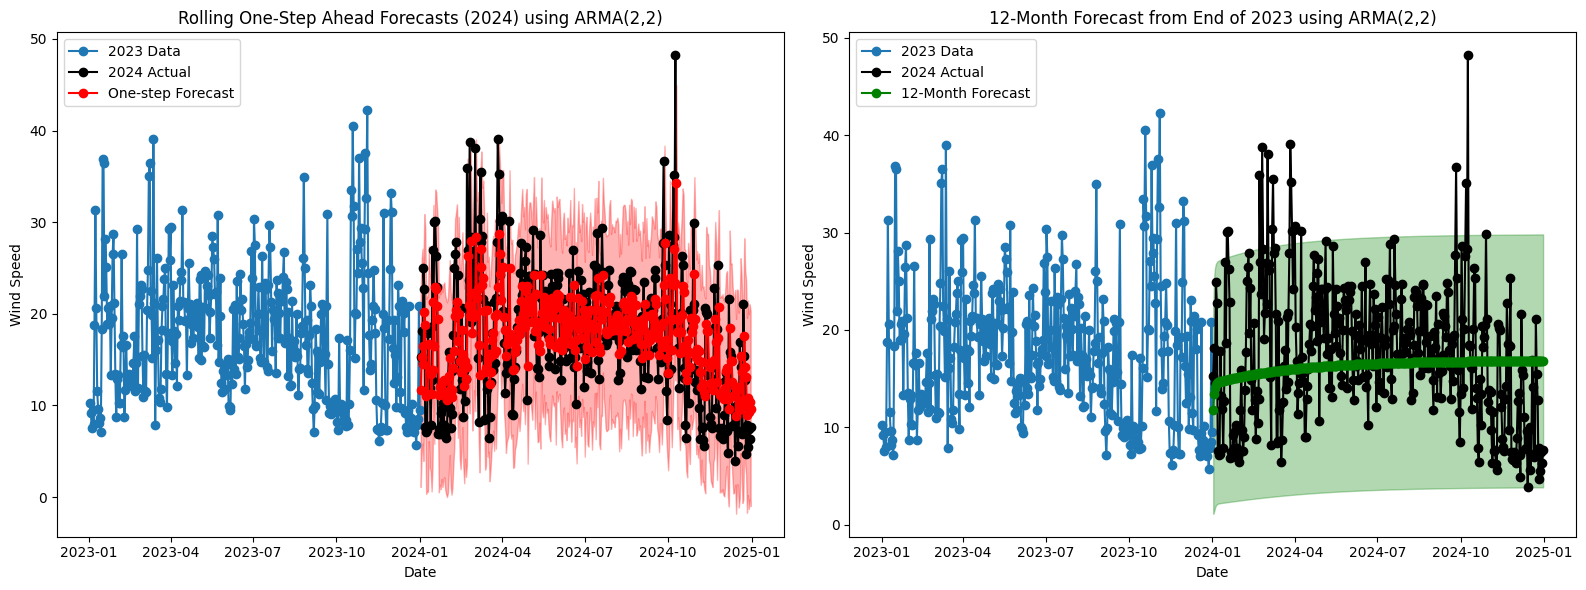

In [25]:
# **12-Month Forecast from the end of 2023**
forecast_res = arma_model.get_forecast(steps=len(test))
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# **Rolling One-Step Ahead Forecast**
current_results = arma_model  # Use the trained model
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []

for date in test.index:
    # Forecast one step ahead
    forecast_obj = current_results.get_forecast(steps=1)
    forecast_value = forecast_obj.predicted_mean.iloc[0]
    ci = forecast_obj.conf_int()

    # Store forecast and confidence intervals
    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci.iloc[0, 0])
    one_step_ci_upper.append(ci.iloc[0, 1])

    # Update model state with actual observation without refitting
    new_observation = pd.Series(test.loc[date, 'wind_speed'], index=[date], name='wind_speed')
    current_results = current_results.append(new_observation, refit=False)

# Convert forecasts and confidence intervals to Pandas Series
one_step_forecasts = pd.Series(one_step_forecasts, index=test.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test.index)

# **Plotting**
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# **Left Plot: Rolling One-Step Ahead Forecasts**
axes[0].plot(train_plot.index, train_plot['wind_speed'], label='2023 Data', marker='o')
axes[0].plot(test.index, test['wind_speed'], label='2024 Actual', color='black', marker='o')
axes[0].plot(one_step_forecasts.index, one_step_forecasts, label='One-step Forecast', color='red', marker='o')
axes[0].fill_between(one_step_forecasts.index, one_step_ci_lower, one_step_ci_upper, color='red', alpha=0.3)
axes[0].set_title("Rolling One-Step Ahead Forecasts (2024) using ARMA(2,2)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Wind Speed")
axes[0].legend()

# **Right Plot: 12-Month Forecast from End of 2023**
axes[1].plot(train_plot.index, train_plot['wind_speed'], label='2023 Data', marker='o')
axes[1].plot(test.index, test['wind_speed'], label='2024 Actual', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label="12-Month Forecast", color='green', marker='o')
axes[1].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
axes[1].set_title("12-Month Forecast from End of 2023 using ARMA(2,2)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Wind Speed")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.6 Model #3: ARIMA

### 3.6.1 Choosing the optimal parameters p, d, q

Here, we apply the same parameter selection process used for the ARMA model, but this time for the ARIMA model, identifying the optimal values for (p, d, q). This process ensures that we select the best combination of autoregressive, differencing, and moving average terms, using BIC as the primary criterion and AIC as a secondary metric to achieve the most accurate and efficient model.

In [26]:
# Define range for AR (p), Differencing (d), and MA (q) orders to test
p = q = range(0, 5)  # Testing values from 0 to 4
d = range(0, 3)  # Testing values for differencing (0, 1, 2)

# Create list of (p, d, q) combinations for ARIMA
pdq_combinations = list(itertools.product(p, d, q))

# Initialize tracking variables
best_bic = np.inf  # Start with a high BIC value
best_aic = np.inf  # Start with a high AIC value
best_order = None

# Loop through each (p, d, q) combination and fit an ARIMA model
for order in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(train['wind_speed'], order=order).fit()
        aic = model.aic  # Extract AIC
        bic = model.bic  # Extract BIC
        
        # First, prioritize the lowest BIC
        if bic < best_bic:
            best_bic, best_aic, best_order = bic, aic, order
        # If two models have the same BIC, choose the one with the lowest AIC
        elif bic == best_bic and aic < best_aic:
            best_aic, best_order = aic, order
    except:
        continue  # Skip models that fail to converge

# Display the best ARIMA model based on BIC (first) and AIC (second)
print(f"Best ARIMA Order: {best_order}, BIC: {best_bic}, AIC: {best_aic}")

Best ARIMA Order: (1, 1, 1), BIC: 20477.328209698517, AIC: 20459.035930802725


In [27]:
# Fit the ARIMA(1,1,1) model on the training data
arima_model = sm.tsa.ARIMA(train['wind_speed'], order=(1, 1, 1)).fit()

# Display model summary
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                 3287
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10226.518
Date:                Thu, 06 Mar 2025   AIC                          20459.036
Time:                        11:13:51   BIC                          20477.328
Sample:                    01-01-2015   HQIC                         20465.585
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4945      0.014     34.731      0.000       0.467       0.522
ma.L1         -0.9764      0.004   -254.998      0.000      -0.984      -0.969
sigma2        29.5418      0.628     47.044      0.0

### 3.6.2 Residual Analysis for ARIMA(1, 1, 1)

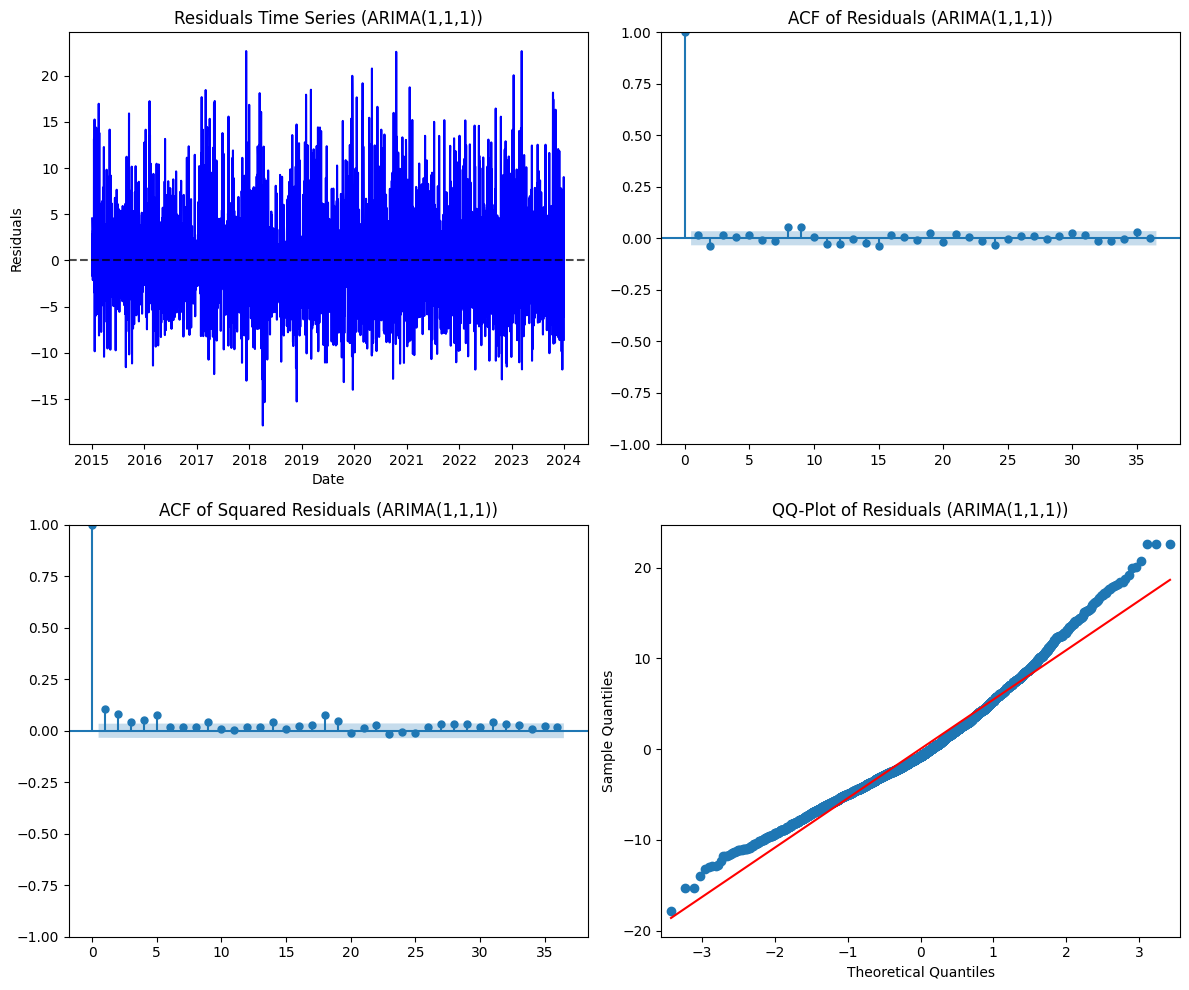

In [28]:
# Fit the ARIMA(1,1,1) model and obtain residuals
model = sm.tsa.ARIMA(train['wind_speed'], order=(1, 1, 1))
results = model.fit()
resid = results.resid  # Extract residuals

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Time Series Plot of Residuals**
axes[0, 0].plot(resid, color='blue')
axes[0, 0].axhline(y=0, linestyle="--", color="black", alpha=0.7)
axes[0, 0].set_title("Residuals Time Series (ARIMA(1,1,1))")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# ACF Plot of Residuals**
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals (ARIMA(1,1,1))")

# ACF Plot of Squared Residuals** (Checks for conditional heteroskedasticity)
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals (ARIMA(1,1,1))")

# QQ-Plot of Residuals** (Checks for normality)
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals (ARIMA(1,1,1))")

plt.tight_layout()
plt.show()

Our conclusions on the residuals for ARIMA(1, 1, 1) Model are:

- Residuals are centered around zero and there's No significant autocorrelation, meaning dependencies are captured well.
- Slight heteroskedasticity (variance instability) could impact forecasts and Heavy tails in QQ-plot indicate occasional large errors.
- ARIMA(1,1,1) is acceptable for forecasting, but improvements are possible.


### 3.6.3 Forecast

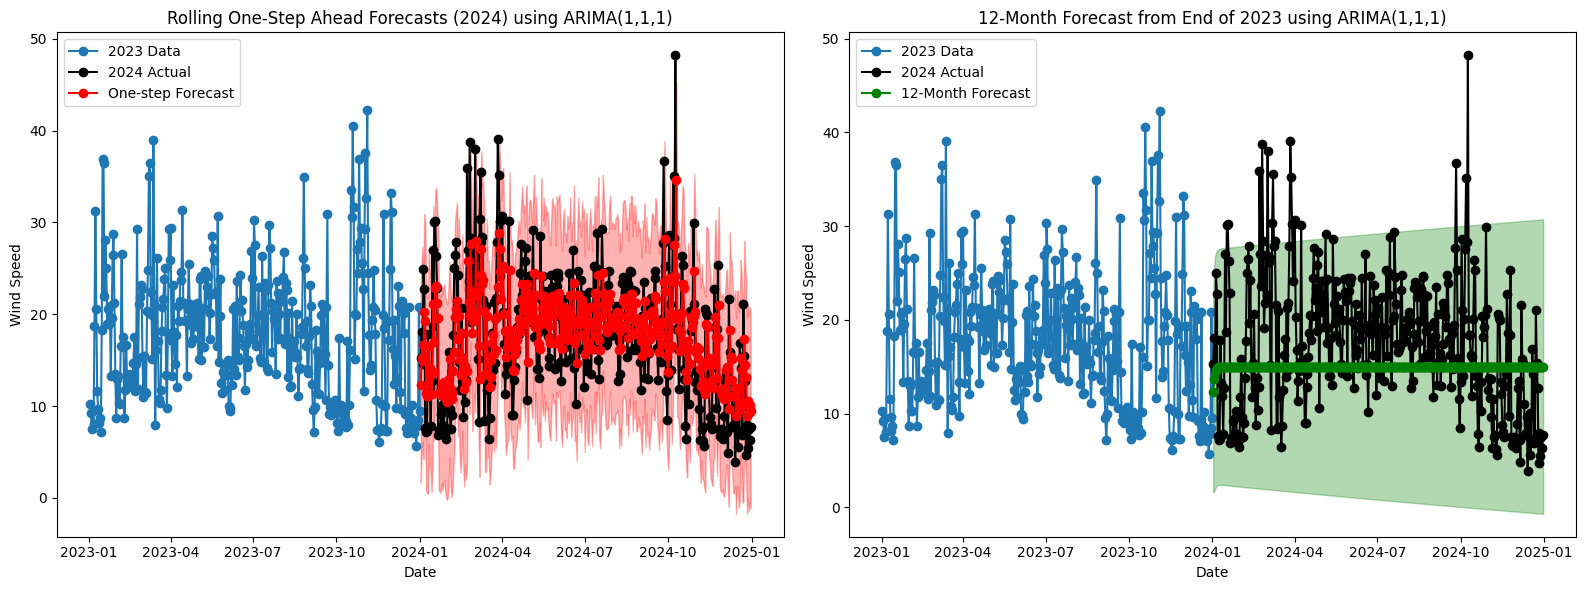

In [29]:
# **Fit ARIMA(1,1,1) Model**
arima_model = sm.tsa.ARIMA(train['wind_speed'], order=(1, 1, 1)).fit()

# **12-Month Forecast from the end of 2023**
forecast_res = arima_model.get_forecast(steps=len(test))
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# **Rolling One-Step Ahead Forecast**
current_results = arima_model  # Use the trained model
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []

for date in test.index:
    # Forecast one step ahead
    forecast_obj = current_results.get_forecast(steps=1)
    forecast_value = forecast_obj.predicted_mean.iloc[0]
    ci = forecast_obj.conf_int()

    # Store forecast and confidence intervals
    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci.iloc[0, 0])
    one_step_ci_upper.append(ci.iloc[0, 1])

    # Update model state with actual observation without refitting
    new_observation = pd.Series(test.loc[date, 'wind_speed'], index=[date], name='wind_speed')
    current_results = current_results.append(new_observation, refit=False)

# Convert forecasts and confidence intervals to Pandas Series
one_step_forecasts = pd.Series(one_step_forecasts, index=test.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test.index)

# **Plotting**
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# **Left Plot: Rolling One-Step Ahead Forecasts**
axes[0].plot(train_plot.index, train_plot['wind_speed'], label='2023 Data', marker='o')
axes[0].plot(test.index, test['wind_speed'], label='2024 Actual', color='black', marker='o')
axes[0].plot(one_step_forecasts.index, one_step_forecasts, label="One-step Forecast", color='red', marker='o')  # FIXED LINE
axes[0].fill_between(one_step_forecasts.index, one_step_ci_lower, one_step_ci_upper, color='red', alpha=0.3)
axes[0].set_title("Rolling One-Step Ahead Forecasts (2024) using ARIMA(1,1,1)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Wind Speed")
axes[0].legend()

# **Right Plot: 12-Month Forecast from End of 2023**
axes[1].plot(train_plot.index, train_plot['wind_speed'], label='2023 Data', marker='o')
axes[1].plot(test.index, test['wind_speed'], label='2024 Actual', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label="12-Month Forecast", color='green', marker='o')
axes[1].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
axes[1].set_title("12-Month Forecast from End of 2023 using ARIMA(1,1,1)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Wind Speed")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.7 Model #4: SARIMA

Here, we apply the same parameter selection process used for the ARMA model, but this time for the SARIMA model, determining the optimal values for (p, d, q, P, D, Q). However, our analysis confirms what we expected—there is no significant seasonality in the time series. This means that wind speed values do not exhibit a strong correlation with those from previous years, indicating that a seasonal component is not necessary for the model.

In [30]:
# Define p, d, q and seasonal P, D, Q
p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = 365  # Assuming yearly seasonality

best_aic = np.inf
best_bic = np.inf
best_order = None
best_seasonal_order = None

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(seasonal_p, seasonal_d, seasonal_q):
        try:
            model = SARIMAX(df['wind_speed'], 
                            order=order, 
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_period)).fit()
            aic = model.aic
            bic = model.bic
            
            if aic < best_aic:
                best_aic = aic
                best_bic = bic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f"Best SARIMA Order: {best_order} Seasonal: {best_seasonal_order}, AIC: {best_aic}, BIC: {best_bic}")

Best SARIMA Order: None Seasonal: None, AIC: inf, BIC: inf


# 4. Model Comparison and Conclusions

In this last section, we evaluate and compare the performance of the three models (AR, ARMA, and ARIMA), using key statistical metrics. The code calculates goodness-of-fit criteria (AIC, BIC), prediction accuracy (RMSE, MAPE), and forecast bias to identify which model provides the best balance between complexity and predictive power. The results are stored in a DataFrame for easy comparison, allowing us to choose the most suitable model for forecasting.

In [31]:
# **Initialize dictionary to store results**
model_results = {}

# **List of models to compare**
models = {
    "AR Model": ar_model, 
    "ARMA Model": arma_model, 
    "ARIMA Model": arima_model
}

# **Loop through each model and compute metrics**
for name, model in models.items():
    # In-Sample Predictions
    in_sample_preds = model.fittedvalues
    in_sample_rmse = np.sqrt(mean_squared_error(train['wind_speed'], in_sample_preds))
    
    # Out-of-Sample Predictions
    forecast_res = model.get_forecast(steps=len(test))
    out_sample_preds = forecast_res.predicted_mean
    out_sample_rmse = np.sqrt(mean_squared_error(test['wind_speed'], out_sample_preds))

    # Compute additional metrics
    aic = model.aic
    bic = model.bic
    mape = mean_absolute_percentage_error(test['wind_speed'], out_sample_preds)
    bias = np.mean(test['wind_speed'] - out_sample_preds)

    # Store results
    model_results[name] = {
        "AIC": aic,
        "BIC": bic,
        "In-Sample RMSE": in_sample_rmse,
        "Out-of-Sample RMSE": out_sample_rmse,
        "MAPE": mape,
        "Forecast Bias": bias
    }

# **Convert results to DataFrame for easy comparison**
import pandas as pd
results_df = pd.DataFrame(model_results).T
results_df

,AIC,BIC,In-Sample RMSE,Out-of-Sample RMSE,MAPE,Forecast Bias
AR Model,20471.539617,20532.516923,5.431574,7.134690,0.418192,0.818404
ARMA Model,20454.409280,20490.995663,5.424027,7.284356,0.405729,1.437829
ARIMA Model,20459.035931,20477.328210,5.436197,7.589830,0.391640,2.699896


## Conclusions

After analyzing the model evaluation metrics, we conclude that the ARIMA(1,1,1) is the most suitable model for forecasting wind speed. This decision is based on its lowest MAPE, indicating the highest forecast accuracy, and its optimal BIC score, which balances model fit and complexity effectively.

While we initially ran all models using the original data, we recognized an important consideration regarding stationarity. Although the Dickey-Fuller test suggested that the original time series was stationary, the ACF plot exhibited a gradual decline, indicating autocorrelation over multiple lags and a potential underlying trend. This discrepancy raised concerns about the true stationarity of the series.

To address this, we applied differencing through ARIMA to ensure proper stationarity and eliminate any remaining trends or seasonal effects. This step was crucial, as it allowed the ARIMA model to perform optimally, confirming that differencing was necessary for achieving a more robust and reliable forecasting model.